### Evaluate imulated ST data run in Qiime2

Input files: <br>
Qiime 2 output feature-table: feature-table.tsv<br>
Qiime 2 output taxonomy: taxonomy.tsv<br>
Simulated custom against SHM-seq database (fastq): metameta$*$matchBarcode.fastq<br>
Simulated custom against SHM-seq database (pickle): metameta$*$.pickle<br>
Simulated truth against SHM-seq database: metameta$*$error1_truth.tsv<br>
DL model: model.h5<br>
DL encoder: encoder.h5<br>

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import random
import sklearn.metrics
from numpy import argmax
from itertools import chain
from scipy.spatial import distance
from functools import reduce
import warnings
import statistics
from scipy import stats
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def parser(filename):
    """
    Generate a list of tuples (header, read)
    """
    fastq_parsed = {}
    try:

        with open(filename) as fq:
            header = next(fq)
            read = next(fq)
            fastq_parsed[header[1:-1].split(' ')[0]] = read[:-1] # we don't want new-line chars or @ sign in reads
            while True:
                next(fq) # skip + line
                next(fq) # skip qscore
                header = next(fq) # store next read header
                read = next(fq) # store next read seq
                fastq_parsed[header[1:-1].split(' ')[0]] = read[:-1]
    except:
        StopIteration # when we run out of reads, stop
    return fastq_parsed

def dna_encode_embedding_table(dna_input, name="dna_encode"):
    embedding_values = np.zeros([len(dna_input), 5], np.float32)
    values = ("A", "C", "G", "T", "N")
    for j, b in enumerate(dna_input):
        if b in values:
            embedding_values[j, values.index(b)] = 1
    return embedding_values

def stack_padding(info_xy):
    # Stack reads into one tensor
    info_xy['one hot tensor'] = info_xy.apply(lambda row: dna_encode_embedding_table(row['read']), axis=1)
    X = np.array(info_xy['one hot tensor'].tolist())

    # Padding to the same sequence length
    masking_value = -1
    max_seq_len = max(len(x) for x in info_xy['one hot tensor'].tolist())
    N = X.shape[0]
    dimension = 5

    Xpad = np.full((N, max_seq_len, dimension), fill_value=masking_value)
    for s, x in enumerate(X):
        seq_len = x.shape[0]
        Xpad[s, 0:seq_len, :] = x
        
    return Xpad

def extract_taxa_info(info_xy, column_header):
    y_taxaorder = info_xy[column_header].tolist()
    y_fastqH = info_xy['fastq'].tolist()
    
    return y_taxaorder, y_fastqH

def predict_taxa_in_model(Xpad, model):
    predictions = model.predict(Xpad)
    
    return predictions

def calculate_missclassified(sant, forutspadd):
    """
    Calculates True postives, false negatives, # NAs and misclassifed taxa when comparing predicted taxa with the 
    groud truth. 
    """
    # percentage of misclassified examples
    if len(sant) != len(forutspadd):
        print('Ground truth and predicted are not the same length.')
        
    true_positives = 0
    missclassified_count = 0
    NA_count = 0
    false_positive = 0
    for pp, prediction in enumerate(forutspadd):
        if prediction == sant[pp]:
            true_positives += 1
        else:
            missclassified_count +=1
            if prediction == 'NA':
                NA_count +=1
            else:
                false_positive +=1

    # Percetage
    TP = true_positives / len(forutspadd) # Note: TP = accuracy
    FN = false_positive / len(forutspadd)
    NA = NA_count / len(forutspadd)
    misclassified = missclassified_count / len(forutspadd)
    
    return TP, FN, NA, misclassified

def change_order(row):
    rv_row = row.split(',')
    rv_row.reverse()
    return ','.join(rv_row) # return species level

def rm_specie(row):
    rv_row = row.split(',')
    if len(rv_row) == 7:
        return ','.join(rv_row[1:]) # return genus level
    else:
        return ','.join(rv_row) # return genus level

# Qiime2

In [3]:
path = ''

### Read feature table
biom = pd.read_csv(os.path.join(path, 'feature-table.tsv'), sep='\t', skiprows=1)
biom.set_index('#OTU ID', inplace=True)

### Read taxonomy table
taxa = pd.read_csv(os.path.join(path, 'taxonomy.tsv'), sep='\t')
taxa_orders = ["Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
taxa[taxa_orders] = taxa["Taxon"].str.split(pat="; ", expand=True)
for taxon in taxa_orders:
    taxa[taxon] = taxa[taxon].str[3:]
    taxa[taxon] = taxa[taxon].fillna('Unassigned')
    
# Qiime2 Silva DB include some additional naming which make the result look worse than what it actually is
taxa['Genus'] = taxa['Genus'].str.replace('Clostridium_sensu_stricto_18','Clostridium')
taxa['Genus'] = taxa['Genus'].str.replace('Clostridium_sensu_stricto_6','Clostridium')
taxa['Genus'] = taxa['Genus'].str.replace('Clostridium_sensu_stricto_1','Clostridium')
taxa['Genus'] = taxa['Genus'].str.replace('UBA1819','Faecalibacterium')
taxa['Genus'] = taxa['Genus'].str.replace("\[Eubacterium\]_eligens_group","Eubacterium")
taxa['Genus'] = taxa['Genus'].str.replace("\[Eubacterium\]_hallii_group","Eubacterium")
taxa['Genus'] = taxa['Genus'].str.replace("\[Ruminococcus\]_gnavus_group","Ruminococcus")
taxa['Genus'] = taxa['Genus'].str.replace("\[Ruminococcus\]_torques_group","Ruminococcus")
taxa['Genus'] = taxa['Genus'].str.replace("Incertae_Sedis","Unassigned")
taxa['Genus'] = taxa['Genus'].str.replace("Muribaculaceae","Unassigned")
taxa['Order'] = taxa['Order'].str.replace('Veillonellales-Selenomonadales', 'Selenomonadales') # Example of unmatching naming between truth and DB
taxa['Order'] = taxa['Order'].str.replace('Peptostreptococcales-Tissierellales', 'Eubacteriales') # Example of unmatching naming between truth and DB
taxa['Order'] = taxa['Order'].str.replace('Lachnospirales', 'Eubacteriales') # Example of unmatching naming between truth and DB
taxa['Order'] = taxa['Order'].str.replace('Oscillospirales', 'Eubacteriales') # Example of unmatching naming between truth and DB
    

In [4]:
# Merge otus with taxonomy
otu = biom.merge(taxa, left_on=biom.index, right_on='Feature ID')
otu.drop(columns=['Taxon', 'Species', 'Feature ID', 'Domain', 'Confidence'], inplace=True)

d = {}
qun_l = []

for tx in taxa_orders[1:6]:
    otu_g = otu.groupby(tx).sum()
    for samp in biom.columns:
        # Calculating Percentage
        otu_g[samp + '_%'] = (otu_g[samp] / otu_g[samp].sum()) * 100
        otu_g.drop(columns=[samp], inplace=True)
    d[tx] = otu_g
    
    # Collect the unassigned
    unassig = otu_g[otu_g.index == 'Unassigned'].T
    if len(unassig.columns) != 1: # No unassigned
        unassig['Unassigned'] = [0, 0, 0]
    unassig['level'] = tx
    unassig['type'] = 'qiime2'
    unassig.rename(columns={'Unassigned':'%'}, inplace=True)
    
    qun_l.append(unassig)

unassign_q2 = pd.concat(qun_l)


# Taxonomy pipeline incl DL

In [5]:
taxa_orders = ["Doamin", "Phylum", "Class", "Order", "Family", "Genus", "Species"]

# Load fastq sample

path = ''

# read input fasta file
fq_d = {}
for file in os.listdir(os.path.join(path, '')):
    if file.endswith("R2_unaligned_matchBarcode.fastq"):
        name = file.split('_R2')[0]
        
        fastq = parser(os.path.join(path, '', file))

        fq_d[name] = fastq


In [6]:
# Load pickle file
info_d = {}
fastq_spot_d = {}

for file in os.listdir(os.path.join(path, '')):
    if file.endswith(".pickle"):
        name = file.split('_fastq')[0]

        with open(os.path.join(path, '', file), 'rb') as handle:
            b = pickle.load(handle)

        info = pd.DataFrame.from_dict(b, orient='index')

        info['read'] = info['fastq'].map(fq_d[name])

        info['taxa_order'] = info.apply(lambda row: change_order(row['taxa_order']), axis=1)
        info['taxa_order'] = info.apply(lambda row: rm_specie(row['taxa_order']), axis=1)
        
        info_d[name] = info
        
        # For truth - get fastq headers per spot
        tmp_d = {}

        for label, group in info.groupby(['x', 'y']):
            spot = label[0].split(':')[-1] + 'x' + label[1].split(':')[-1]
            tmp_d[spot] = group['fastq'].tolist()
            
        fastq_spot_d[name] = tmp_d


## Load model and encoder

In [7]:
input_path = '../bacterial_preparation_scripts/files'
input_model = 'model.h5'

model = keras.models.load_model(os.path.join(input_path, input_model))
# summarize model.
model.summary()

input_encoder = 'encoder.h5'

encoder = pickle.load(open(os.path.join(input_path, input_encoder), 'rb'))

Metal device set to: Apple M1


2023-05-25 13:14:45.478248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-25 13:14:45.479304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 masking (Masking)              (None, None, 5)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     4864        ['masking[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     5504        ['masking[0][0]']                
                                                                                            

In [8]:
########### Kraken2 + DL reassignment #############

# Go through all the spots
clusterl_d = {}
reassign_D = {}

for infok, info in info_d.items():

    cluster_l = []
    reassign_d = {} 
    test_count = 0
    unassigned_by_DL = 0
    unassigned_by_DL_fastq = []

    info_coordXY = info.loc[:,['x','y']]
    info_coordXY.drop_duplicates(inplace=True)
    info_coordXY['tuple'] = list(zip(info_coordXY['x'], info_coordXY['y']))

    for tup in info_coordXY['tuple'].tolist():
        newcluster_d = {}

        spot_coord = tup[0].split(':')[-1] + 'x' + tup[1].split(':')[-1]        
        # Select one spot to start with
        info_xy = info[(info['x'] == tup[0]) & (info['y'] == tup[1])]

        if info_xy.shape[0] >0:
            Xpad = stack_padding(info_xy) # Stacking and padding/masking of reads
            y_taxaorder, fastqH = extract_taxa_info(info_xy, 'taxa_order') # Collect taxa info
            predictions = predict_taxa_in_model(Xpad, model) # Predict assignments using model

            rv_predictions = encoder.inverse_transform(predictions.argmax(axis=1)) # Predict taxa using encoder

            # Reassign taxa based on prediciton
            new_taxaorder = []

            for i, taxon in enumerate(y_taxaorder):
                if taxon.startswith('Unassigned'):
                    new_taxa = rv_predictions[i]

                    # If unassigned by DL model
                    if new_taxa == '':
                        new_taxa = unassigned_string
                        unassigned_by_DL += 1
                        unassigned_by_DL_fastq.append(fastqH[i])

                    new_taxaorder.append(new_taxa)
                else:
                    new_taxaorder.append(taxon)

            newcluster_d[spot_coord] = dict(Counter(new_taxaorder))

            reassign_d[spot_coord] = pd.DataFrame({'fastq':fastqH, 'Predicted':new_taxaorder, 'Kraken2':y_taxaorder})

            cluster_l.append(newcluster_d)
            test_count +=1
    
    clusterl_d[infok] = cluster_l
    reassign_D[infok] = reassign_d


2023-05-25 13:15:14.128720: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-25 13:15:14.918646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-25 13:15:15.531344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-25 13:15:15.540032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-25 13:15:17.376899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-25 13:15:17.385492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 129ms/step


25/25 [==============================] - 3s 101ms/step


25/25 [==============================] - 2s 83ms/step


16/16 [==============================] - 2s 104ms/step


14/14 [==============================] - 2s 114ms/step


18/18 [==============================] - 2s 113ms/step


13/13 [==============================] - 2s 128ms/step


10/10 [==============================] - 1s 134ms/step


26/26 [==============================] - 3s 125ms/step


11/11 [==============================] - 1s 113ms/step


10/10 [==============================] - 2s 162ms/step


In [9]:
# Make DL results to bulk

tx_rv = ["Species", "Genus", "Family", "Order", "Class", "Phylum", "Domain"]

unassign_cust = {}
rel_abund_cust = {}

for sample in biom.columns:
    v = clusterl_d[sample + '_error1'] # iteate through all the DL samples
    
    il = []
    
    for iv in v:
        for jk, jv in iv.items(): # Iterate through the spots
        
            idf = pd.DataFrame.from_dict(jv, orient='index').reset_index()
            idf.columns = ['taxa', 'count']
            il.append(idf)

    l = pd.concat(il)
    l[tx_rv[1:]] = l["taxa"].str.split(pat=",", expand=True)

    for tx_level in tx_rv[1:-1]:
        ltx = l.groupby(tx_level).sum().reset_index()
        ltx['%'] = (ltx['count'] / ltx['count'].sum()) * 100

        # Save unassigned
        if ltx[ltx[tx_level] == 'Unassigned'].shape[0] >0:
            unass = ltx[ltx[tx_level] == 'Unassigned']['%'][0]
        else:
            unass = 0

        if not tx_level in unassign_cust:
            unassign_cust[tx_level] = [unass]
        else:
            unassign_cust[tx_level].append(unass)

        rel_abund_cust[sample + '_' + tx_level] = ltx[[tx_level, '%']].set_index(tx_level)
            

# Evaluate against the truth

In [10]:
# Current assignments
truth_path = ''
truth_d = {}
for file in os.listdir(truth_path):
    if file.endswith("truth.tsv"):
        name = file.split('_truth')[0]
    
        truth = pd.read_csv(os.path.join(truth_path, file))

        truth[tx_rv] = truth["full taxa"].str.split(pat=",", expand=True)

        # Remove Nan in full taxa
        truth.dropna(subset=['full taxa'], inplace=True)
        
        for tx in tx_rv[1:6]:
            truth_g = truth.groupby(tx).count()[['index']]
            
            # Calculating Percentage
            truth_g[name.split('_')[0] + '_%'] = (truth_g['index'] / truth_g['index'].sum()) * 100
            truth_g.drop(columns=['index'], inplace=True)
    
            truth_d[name.split('_')[0] + '_%_' + tx] = truth_g
              

In [12]:
# Pearson's correltion $ Bray-Curtis
pearsonq_d = {}
braycurtisq_d ={}
pearsonk_d = {}
braycurtisk_d ={}

for tx in tx_rv[1:6]:
    
    for samp in biom.columns:
        
        dff = truth_d[samp + '_%_' + tx].merge(d[tx][samp + '_%'], 
                                               left_on=truth_d[samp + '_%_' + tx].index, 
                                               right_on=d[tx][samp + '_%'].index,
                                              how='outer').fillna(0)
        dff.columns = ['taxon', 'truth', 'qiime2']
        
        dff = dff.merge(rel_abund_cust[samp + '_' + tx], 
                        left_on='taxon', 
                        right_on=rel_abund_cust[samp + '_' + tx].index,
                       how='outer').fillna(0)

        dff.columns = ['taxon', 'truth', 'qiime2', 'KrakenDL']
        
        # Pearson correlation
        pearq = stats.pearsonr(dff['truth'].tolist(), dff['qiime2'].tolist())[0]
        peark = stats.pearsonr(dff['truth'].tolist(), dff['KrakenDL'].tolist())[0]
        
        if samp not in pearsonq_d:
            pearsonq_d[samp] = [pearq]
        else:
            pearsonq_d[samp].append(pearq)
            
        if samp not in pearsonk_d:
            pearsonk_d[samp] = [peark]
        else:
            pearsonk_d[samp].append(peark)
        
        # Bary-Curtis
        bcq = distance.braycurtis(dff['truth'].tolist(), dff['qiime2'].tolist())
        bck = distance.braycurtis(dff['truth'].tolist(), dff['KrakenDL'].tolist())
        
        if samp not in braycurtisq_d:
            braycurtisq_d[samp] = [bcq]
        else:
            braycurtisq_d[samp].append(bcq)
        if samp not in braycurtisk_d:
            braycurtisk_d[samp] = [bck]
        else:
            braycurtisk_d[samp].append(bck)

dl1 = [pearsonq_d, braycurtisq_d, pearsonk_d, braycurtisk_d]
dl = []
for i, di in enumerate(dl1):
    d1 = pd.DataFrame.from_dict(di, orient='index',columns=tx_rv[1:6])

    d1.reset_index(inplace=True)

    d1 = pd.melt(d1, id_vars=['index'], value_vars=tx_rv[1:6])
    
    if i in [0, 1]:
        d1['method'] = 'qiime2'
    else:
        d1['method'] = 'KrakenDL'

    dl.append(d1)


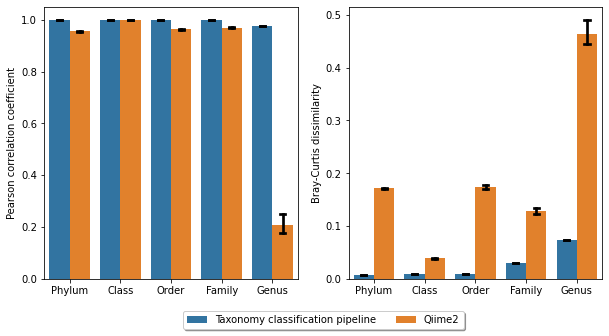

In [13]:
legend_labels = {'KrakenDL':'Taxonomy classification pipeline',
                'qiime2':'Qiime2'}

# Plot
# for a 2x3 subplot
fig = plt.figure(figsize=(10,5))
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,2):
        ax = plt.subplot2grid((1, 2), (row_idx, col_idx))
        axes.append(ax)
        
ylabels = ['Pearson correlation coefficient', 'Bray-Curtis dissimilarity']

for i, di in enumerate(dl[:2]):
    ax=axes[i]
    
    di_concat = pd.concat([di, dl[i+2]]).reset_index()
    di_concat = di_concat.iloc[::-1]

    di_concat.method = di_concat.method.map(legend_labels)
    
    sns.barplot(data=di_concat, x='variable', y='value', hue='method', ax=ax, estimator=np.mean, ci=95, capsize=.1, errcolor='black')

    ax.set_ylabel(ylabels[i])
    ax.set_xlabel("")
    
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(1.1, -0.1),
          fancybox=True, shadow=True, ncol=2)
    else:
        ax.get_legend().remove()
